## Modules à importer

In [1]:
from importlib import reload
from variaIa.variaIa import baserate
from scipy import interpolate
import math

## Définitions et sélection de l'échantillon à utiliser

In [29]:
import pandas as pd

d = pd.read_csv('../Data/data_cheat.csv',
                sep=' ', index_col = 'CID')

import numpy as np
import iminuit as im
from scipy.stats import poisson
from astropy.cosmology import Planck15 as cdata
import matplotlib.pyplot as plt
plt.style.use('classic')
import random
import ipywidgets as ipw

surveys = ['SDSS', 'SNLS', 'PS1', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'SNLS')

surv = {'SDSS': d[d['IDSURVEY'] == 1],
        'SNLS': d[d['IDSURVEY'] == 4],
        'PS1':  d[d['IDSURVEY'] == 15],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

colors = {'SDSS': 'lime',
          'SNLS': 'red',
          'PS1': 'blue',
          'HST': 'purple'}

def set_data(su):
    global ns_dataz, dataz, ns_datax, datax
    ns_dataz = surv[su].zCMB.values
    dataz = np.sort(ns_dataz)
    ns_datax = surv[su].x1.values
    datax = np.sort(ns_datax)
    
int_data = ipw.interactive(set_data, su = su)
display(int_data)

cut = np.where(ns_dataz<zmax[su.value])

interactive(children=(Dropdown(description='Survey:', index=1, options=('SDSS', 'SNLS', 'PS1', 'HST'), value='…

## Choix des bins pour les listes de redshifts et de strech

In [3]:
nb_z = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for z:', continuous_update=False)

def set_bins_z(nb_z):
    global binsz, bordz, countsz
    bordz = np.asarray(np.histogram(dataz, bins = nb_z)[1])
    binsz = np.asarray([[bordz[i],bordz[i+1]] for i in range(len(bordz)-1)]).T
    countsz = np.histogram(dataz, bordz)[0]
    
int_bins_z = ipw.interactive(set_bins_z, nb_z = nb_z)
display(int_bins_z)

nb_x = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for x:', continuous_update=False)

def set_bins_x(nb_x):
    global binsx, bordx, countsx
    bordx = np.asarray(np.histogram(datax, bins = nb_x)[1])
    binsx = np.asarray([[bordx[i],bordx[i+1]] for i in range(len(bordx)-1)]).T
    countsx = np.histogram(datax, bordx)[0]
    
int_bins_x = ipw.interactive(set_bins_x, nb_x = nb_x)
display(int_bins_x)

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for z:', max=30, min=3),…

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for x:', max=30, min=3),…

## Tracé du strech de l'échantillon choisi, coupé à zmax

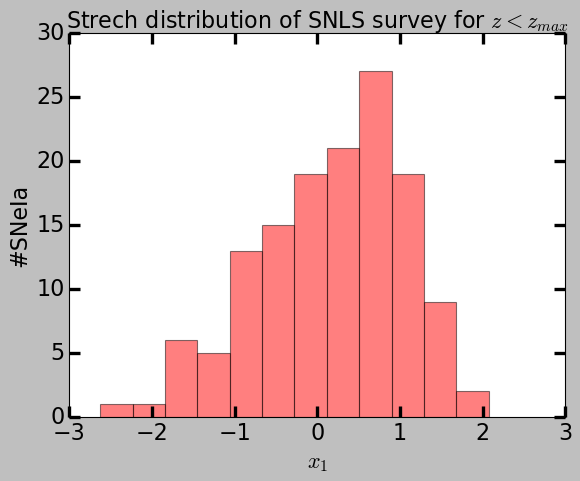

In [31]:
plt.hist(np.sort(ns_datax[cut]), bins = nb_x.value, color = colors[su.value], alpha = .5)

ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('#SNeIa', fontsize = 20)

plt.title('Strech distribution of ' + str(su.value) + ' survey for $z < z_{max}$', fontsize = 20)

plt.show()

## Définitions des dictionnaires généraux : $z < z_{\text{max}}$ cuts

In [30]:
zmax = {'SDSS': 0.22,
        'SNLS': 0.70,
        'PS1': 0.33,
        'HST': 1.2}

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()

for survey in surveys:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < zmax[survey])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]

## Tracé des strechs cut à $z_{\text{max}}$

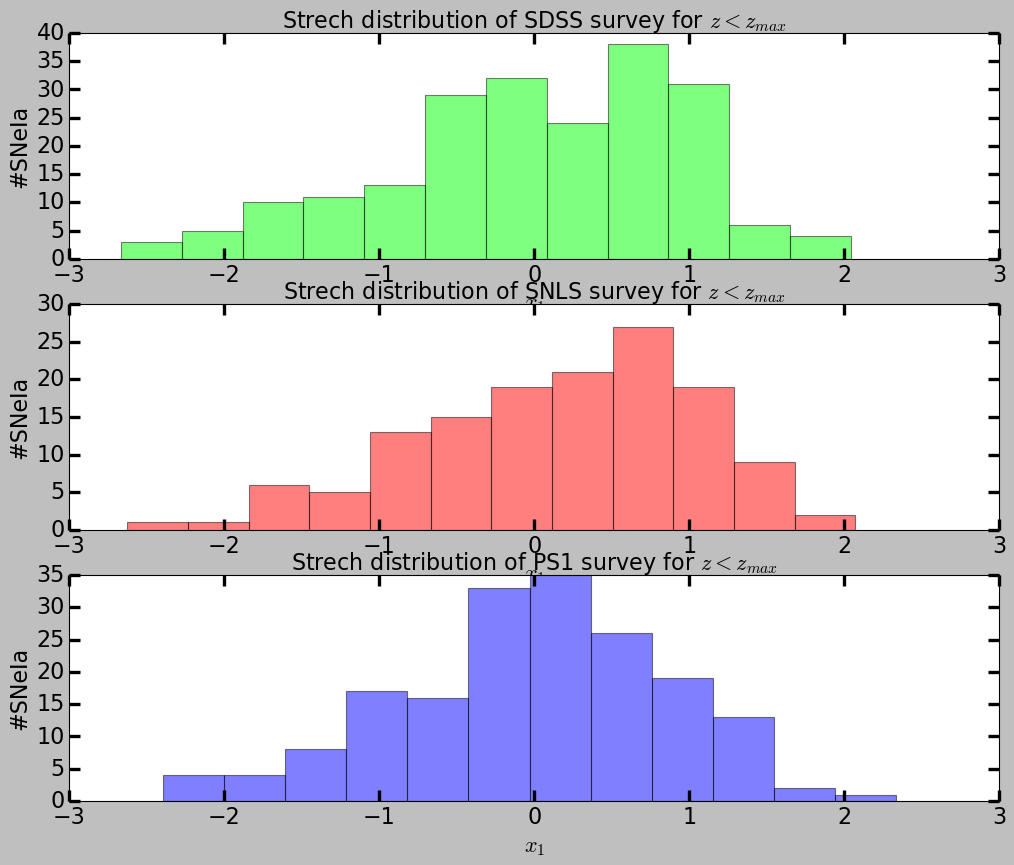

In [32]:
plt.figure(figsize = [15,12])

for i in range(len(surveys[:-1])):
    plt.subplot(3, 1, i+1)
    plt.hist(x1_zcuts[surveys[i]], bins = nb_x.value, color = colors[surveys[i]], alpha = .5)

    ax = plt.gca()
    ax.tick_params(axis = 'both',
                   direction = 'in',
                   length = 10, width = 3,
                   labelsize = 20,
                   which = 'both',
                   top = True, right = True)
    plt.xlabel('$x_1$', fontsize = 20)
    plt.ylabel('#SNeIa', fontsize = 20)

    plt.title('Strech distribution of ' + surveys[i] + ' survey for $z < z_{max}$', fontsize = 20)

plt.show()

## Définition des dictionnaires généraux : median

In [8]:
z_med = dict()
x1_med = dict()

for survey in surveys:
    z_med[survey] = np.median(z_zcuts[survey])
    x1_med[survey] = np.median(x1_zcuts[survey])

## Définition des dictionnaires généraux : $x_1 < -0.5$ cuts

In [66]:
xmax_cuts = dict()
x1_xcuts = dict()
z_xcuts = dict()

for survey in surveys:
    xmax_cuts[survey] = np.where(x1_zcuts[survey] < -.5)
    x1_xcuts[survey] = x1_zcuts[survey][xmax_cuts[survey]]
    z_xcuts[survey] = z_zcuts[survey][xmax_cuts[survey]]

## Tracé des $x_{\text{med}}$ en fonction des $z_{\text{med}}$

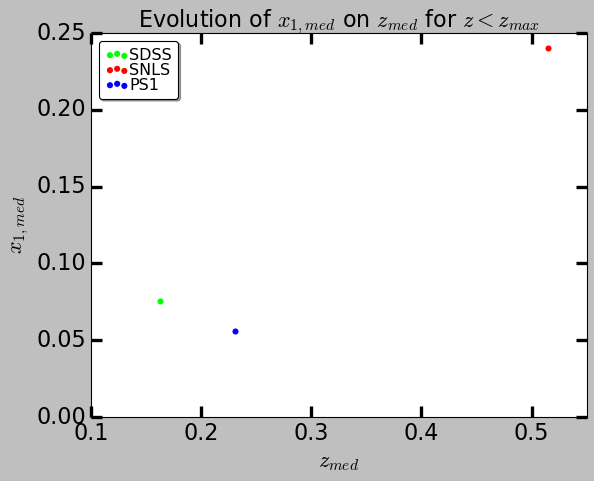

In [73]:
for i in range(3):
    plt.scatter(list(z_med.values())[i], list(x1_med.values())[i],
                color = list(colors.values())[i], label = surveys[i])

ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$z_{med}$', fontsize = 20)
plt.ylabel('$x_{1,med}$', fontsize = 20)

plt.legend(ncol=1, loc='upper left', 
           #bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

plt.title('Evolution of $x_{1,med}$ on $z_{med}$ for $z < z_{max}$', fontsize = 20)

plt.show()

## Tracé de la fraction de SNe de $x_1 < -0.5$ en fonction de $z_{\text{med}}$

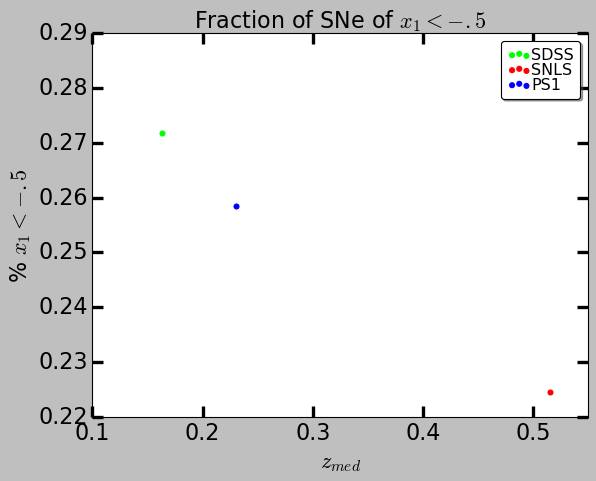

In [74]:
for i in range(3):
    plt.scatter(z_med[surveys[i]], len(x1_xcuts[surveys[i]])/len(x1_zcuts[surveys[i]]),
                color = colors[surveys[i]], label = surveys[i])

ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$z_{med}$', fontsize = 20)
plt.ylabel('% $x_1 < -.5$', fontsize = 20)

plt.legend(ncol=1, loc='upper right', 
           #bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

plt.title('Fraction of SNe of $x_1 < -.5$', fontsize = 20)

plt.show()

## Tracé des $x_{\text{med}}$ et de la fraction de SNe de $x_1 < -0.5$ en fonction des $z_{\text{med}}$

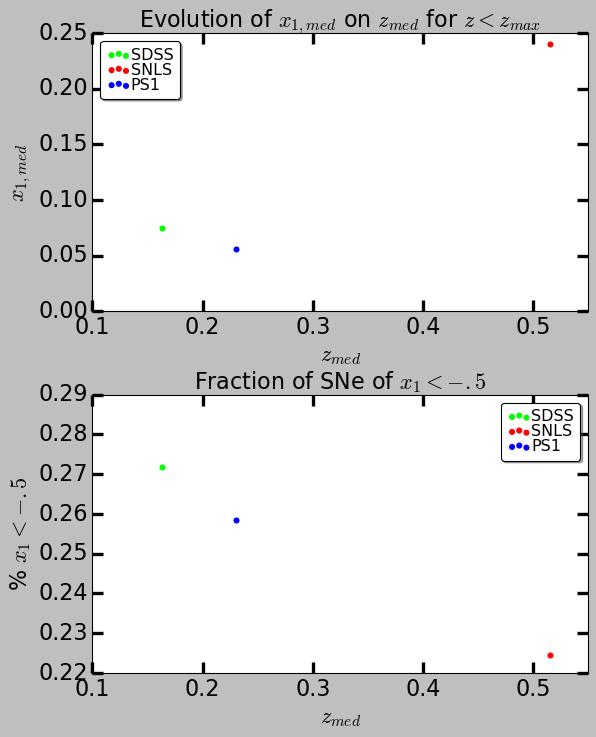

In [84]:
plt.figure(figsize = [8,10])

plt.subplot(211)

for i in range(3):
    plt.scatter(list(z_med.values())[i], list(x1_med.values())[i],
                color = list(colors.values())[i], label = surveys[i])

ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$z_{med}$', fontsize = 20)
plt.ylabel('$x_{1,med}$', fontsize = 20)

plt.legend(ncol=1, loc='upper left', 
           #bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

plt.title('Evolution of $x_{1,med}$ on $z_{med}$ for $z < z_{max}$', fontsize = 20)

plt.subplot(212)

for i in range(3):
    plt.scatter(z_med[surveys[i]], len(x1_xcuts[surveys[i]])/len(x1_zcuts[surveys[i]]),
                color = colors[surveys[i]], label = surveys[i])

ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$z_{med}$', fontsize = 20)
plt.ylabel('% $x_1 < -.5$', fontsize = 20)

plt.legend(ncol=1, loc='upper right', 
           #bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

plt.title('Fraction of SNe of $x_1 < -.5$', fontsize = 20)

plt.subplots_adjust(hspace = .3)

plt.show()

## Tracé des $x_1 < -0.5$ en fonction de $z$

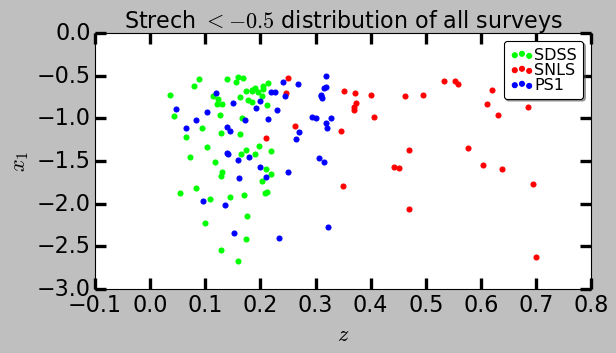

In [67]:
plt.figure(figsize = [8,4])

for i in range(len(surveys[:-1])):
    #plt.subplot(3, 1, i+1)
    plt.scatter(z_xcuts[surveys[i]], x1_xcuts[surveys[i]], color = colors[surveys[i]], label = surveys[i])

ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$z$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)

plt.legend(ncol=1, loc='upper right', 
           #bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

plt.title('Strech $< - 0.5$ distribution of all surveys', fontsize = 20)

plt.show()

## Base model

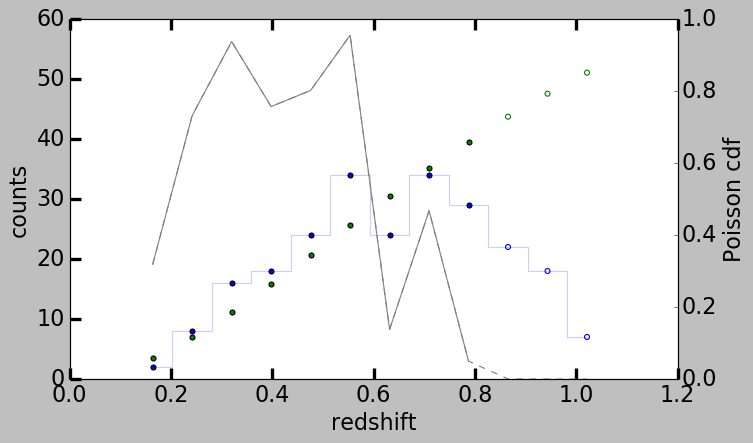

In [9]:
reload(baserate)

base = baserate.BaseRateModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(countsz, binsz)
ratefitter.set_model(base)
ratefitter.set_fitted_flag(ratefitter._central_redshiftranges < 0.8)
ratefitter.fit(a_guess = 0.2)
_ = ratefitter.show(add_proba = True)

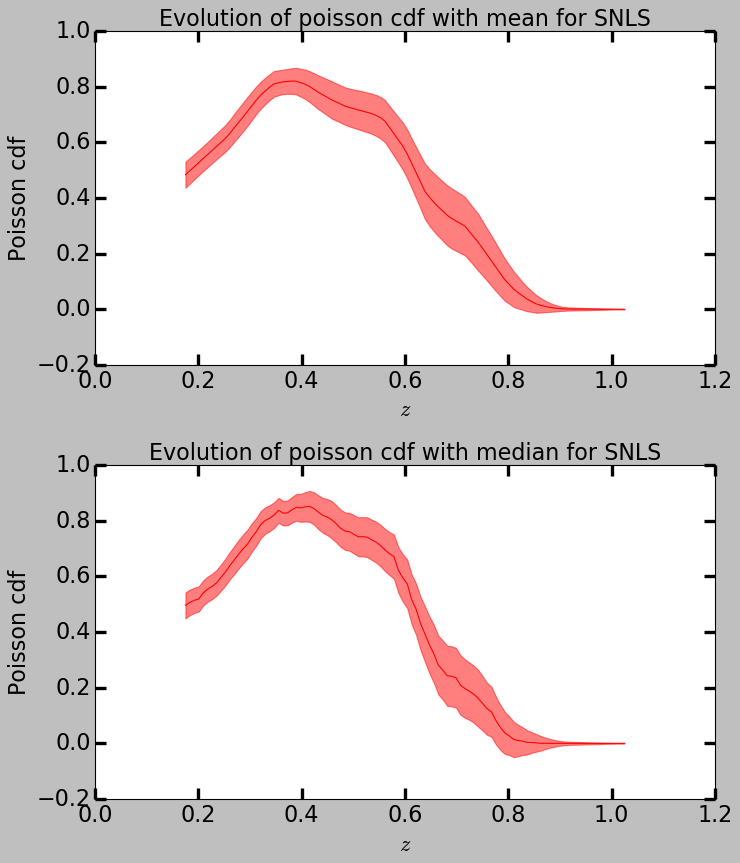

In [11]:
reload(baserate)
baserate.pshow_r(su.value, dataz, 0.2, 100)

## Expo Model

{'b': 5316.234720963694, 'zmax': 0.7486620139677895, 'zc': 0.07845836687013252}

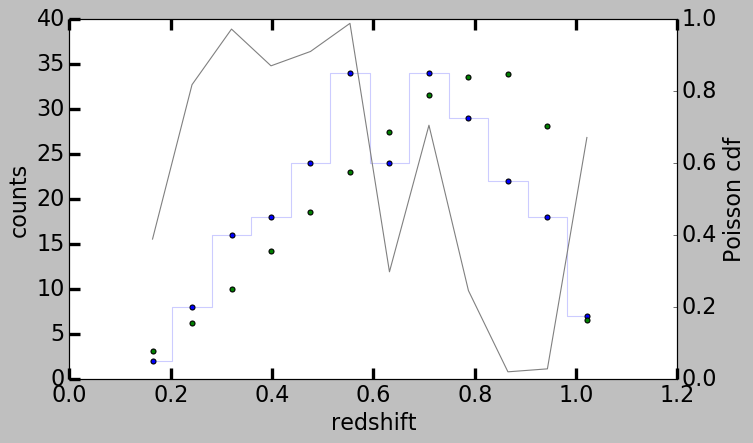

In [21]:
reload(baserate)

expo = baserate.ExpoRateModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(counts, bins)
ratefitter.set_model(expo)
#ratefitter.set_fitted_flag(ratefitter._central_redshiftranges < 0.7)
ratefitter.fit(a_guess = 0.2, b_guess = 1, zmax_guess = 0.7, zc_guess = 1e-1,\
               #b_fixed = True, zmax_fixed = True, zc_fixed = True\
              )
_ = ratefitter.show(add_proba = True)
expo.parammissed

## Const model

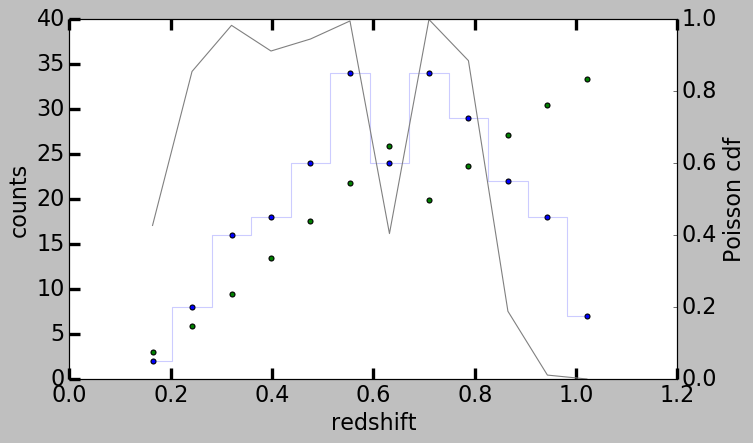

In [37]:
reload(baserate)

const = baserate.ConstRateModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(counts, bins)
ratefitter.set_model(const)
#ratefitter.set_fitted_flag(ratefitter._central_redshiftranges<0.7)
ratefitter.fit(a_guess = 0.2, zmax_guess = 0.7,\
               zmax_fixed = True)
_ = ratefitter.show(add_proba = True)

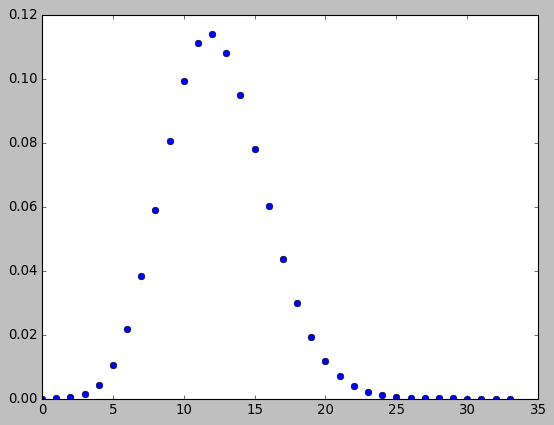

In [29]:
plt.plot(np.arange(0,np.max(data)), poisson.pmf(np.arange(0,np.max(data)),base.get_expectedrate(ratefitter.redshift_ranges)[2]), 'bo')